In [4]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [ ]:
%pip install opendatasets -q --upgrade

In [ ]:
import opendatasets as od
od.dowload('https://www.kaggle.com/puneet6060/intel-image-classification')

In [5]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
get_class = {v: k for k, v in class_names_label.items()}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

In [6]:
class_names_label, get_class

({'mountain': 0,
  'street': 1,
  'glacier': 2,
  'buildings': 3,
  'sea': 4,
  'forest': 5},
 {0: 'mountain',
  1: 'street',
  2: 'glacier',
  3: 'buildings',
  4: 'sea',
  5: 'forest'})

In [8]:
import os
os.listdir('/kaggle/input/intel-image-classification')

['seg_train', 'seg_pred', 'seg_test']

In [9]:
def load_data():
    datasets = ['../input/intel-image-classification/seg_train/seg_train', 
                '../input/intel-image-classification/seg_test/seg_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []

        print(f"Loading {dataset}")

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:14<00:00, 167.00it/s]


Loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:03<00:00, 179.94it/s]


In [12]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [13]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


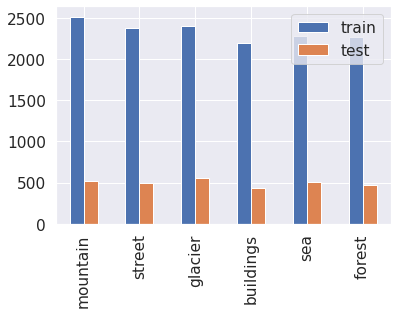

In [14]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

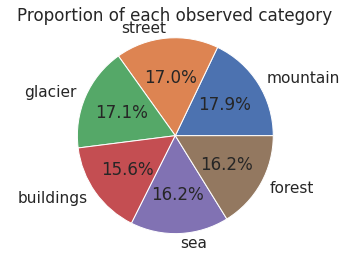

In [15]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [16]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [17]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

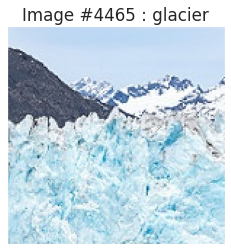

In [18]:
display_random_image(class_names, train_images, train_labels)

In [19]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

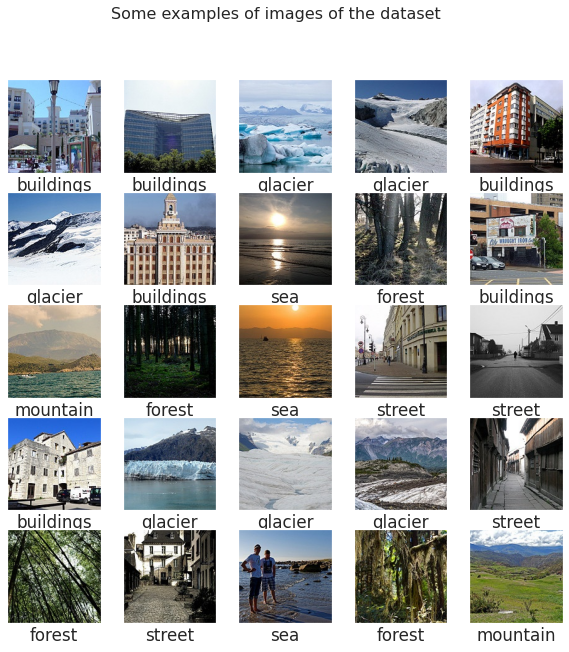

In [20]:
display_examples(class_names, train_images, train_labels)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu'),
    tf.keras.layers.Conv2D(50, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

2022-10-23 07:42:17.928158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 07:42:18.028709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 07:42:18.029557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 07:42:18.031091: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=30, validation_split = 0.2)

2022-10-23 07:45:20.360290: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3031290000 exceeds 10% of free system memory.
2022-10-23 07:45:23.904892: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3031290000 exceeds 10% of free system memory.
2022-10-23 07:45:26.320500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-10-23 07:45:27.705467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


88/88 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.4573

2022-10-23 07:45:46.433721: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 757890000 exceeds 10% of free system memory.
2022-10-23 07:45:47.330393: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 757890000 exceeds 10% of free system memory.


88/88 [==============================] - 23s 166ms/step - loss: 1.3975 - accuracy: 0.4573 - val_loss: 0.9659 - val_accuracy: 0.6555
Epoch 2/30
88/88 [==============================] - 11s 125ms/step - loss: 1.0934 - accuracy: 0.5946 - val_loss: 0.8264 - val_accuracy: 0.7075
Epoch 3/30
88/88 [==============================] - 11s 126ms/step - loss: 0.9262 - accuracy: 0.6579 - val_loss: 0.6924 - val_accuracy: 0.7542
Epoch 4/30
88/88 [==============================] - 11s 125ms/step - loss: 0.8452 - accuracy: 0.6900 - val_loss: 0.6635 - val_accuracy: 0.7624
Epoch 5/30
88/88 [==============================] - 11s 125ms/step - loss: 0.7578 - accuracy: 0.7300 - val_loss: 0.6363 - val_accuracy: 0.7770
Epoch 6/30
88/88 [==============================] - 11s 126ms/step - loss: 0.6579 - accuracy: 0.7663 - val_loss: 0.6043 - val_accuracy: 0.7934
Epoch 7/30
88/88 [==============================] - 11s 124ms/step - loss: 0.6138 - accuracy: 0.7795 - val_loss: 0.6130 - val_accuracy: 0.7795
Epoch 8/30

In [24]:
model.save('model.h5')

In [31]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,20))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

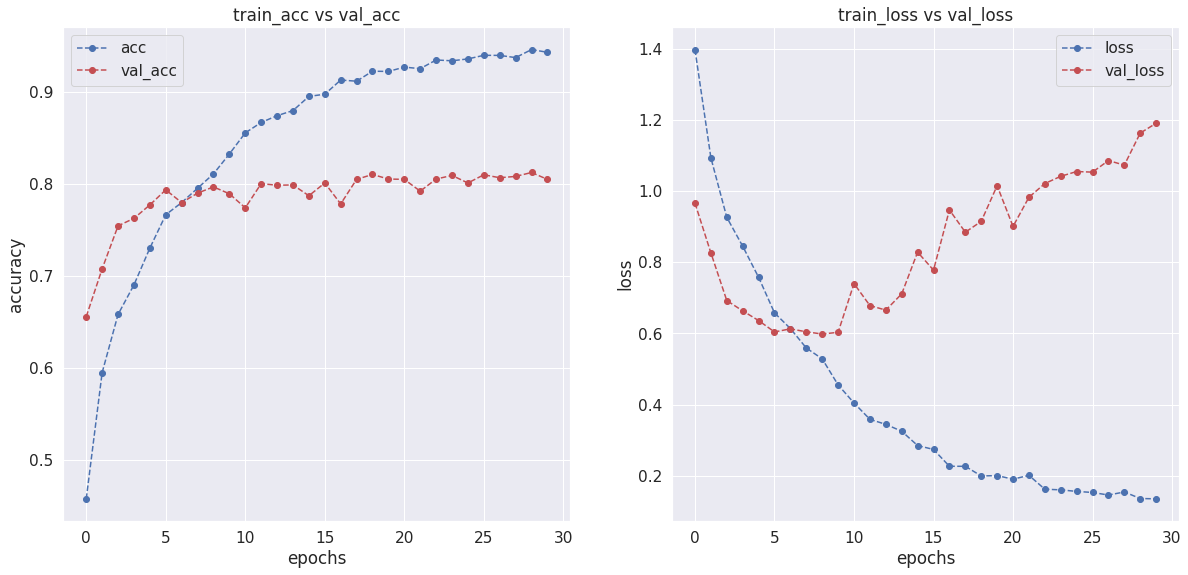

In [32]:
plot_accuracy_loss(history)

In [33]:
test_loss = model.evaluate(test_images, test_labels)

2022-10-23 07:54:36.445360: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 810000000 exceeds 10% of free system memory.


94/94 [==============================] - 2s 13ms/step - loss: 1.1909 - accuracy: 0.8093


In [34]:
from PIL import Image

In [36]:
test_image = '../input/intel-image-classification/seg_pred/seg_pred/10034.jpg'
img = Image.open(test_image)
image_array = np.asarray(img)

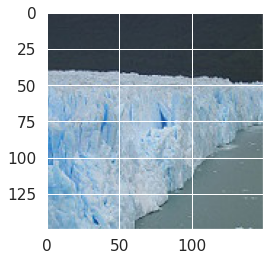

In [37]:
plt.imshow(image_array)

In [38]:
model_x = tf.keras.models.load_model('/kaggle/working/model.h5')

In [40]:
preds = model_x.predict(np.asarray([image_array]))

In [42]:
get_class[np.argmax(preds)]

'glacier'

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
model = tf.keras.models.load_model('/Users/prabhukiran/Downloads/archive/model.h5')
test_image = '/Users/prabhukiran/Downloads/archive/seg_train/seg_train/buildings/53.jpg'
img = Image.open(test_image)
image_array = np.asarray(img)
preds = model.predict(np.asarray([image_array]))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-23 19:24:00.069354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-23 19:24:00.069772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/1 [==============================] - 0s 204ms/step


2022-10-23 19:24:00.489288: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-23 19:24:00.574020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [5]:
preds

array([[0., 0., 0., 1., 0., 0.]], dtype=float32)

In [6]:
np.argmax(preds)

3

In [3]:
getclass = {0: 'mountain',
                1: 'street',
                2: 'glacier',
                3: 'buildings',
                4: 'sea',
                5: 'forest'}

getclass[np.argmax(preds)]

'buildings'

In [11]:
img = tf.keras.preprocessing.image.load_img('/Users/prabhukiran/Downloads/archive/4.JPEG')

In [20]:
x = tf.keras.preprocessing.image.img_to_array(img)

In [17]:
x = np.asarray([x])

In [18]:
model.predict(np.asarray(x))

1/1 [==============================] - 0s 18ms/step


array([[0., 0., 0., 1., 0., 0.]], dtype=float32)